# 코인판 크롤러 프로그램

해당 프로그램은 2022년 11월에 제작됐으며, 향후 코인판 홈페이지의 개편이나 보안 강화가 이뤄질 경우, 해당 프로그램이 작동되지 않을 수 있습니다.

In [1]:
#module import 

import time
import json
import urllib
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from konlpy.tag import Okt

okt = Okt()

In [18]:
plt.rcParams["font.family"] = "Hancom MalangMalang"

In [4]:
#function

def word_counter(value, key_words):
    for i in value:
        if i not in key_words:
            key_words[i] = 1 #최초 언어
        elif i in key_words:
            key_words[i] += 1 #중복 언어
    return key_words


def tokenizer(text):
    for i in text:
        word = okt.nouns(i) #토큰화
    return text


def counter_to_DataFrame(key_words):
    word_df = pd.DataFrame(key_words.items()) #Data Frame 형성
    word_df.columns = ['단어', '빈도']
    word_df = word_df.sort_values(['빈도'],ascending = False).reset_index(drop = True) #내림차순 정렬
    return word_df


## 크롤링 프로그램
하단의 프로그램을 통해 코인판의 내용을 크롤링 할 수 있습니다

In [5]:
iter = 100    #몇 페이지까지 크롤링 할 것인지?

In [6]:
key_words = {}
word_lis = []

for i in range(iter):
    url = 'https://coinpan.com/index.php?mid=free&page=' + str(i)
    
    #딜레이 생성
    seed = np.random.randint(100)
    np.random.seed(seed)
    a = np.random.randint(5)
    time.sleep(a)

    #url 호출
    session = requests.session()
    res = session.get(url)
    res.raise_for_status()

    #html 추출
    soup = BeautifulSoup(res.text, 'html.parser')
    a = soup.find_all("td", attrs = {'class':'title'}) #제목이 들어있는 태그의 텍스트 추출
    text = str(a)
    num = len(a)
    words = re.compile('[가-힣]+').findall(text) #한글 제외 전부 제거
    words = words[23:-18] #불용어 제거

    token = tokenizer(words) #토큰화
    word_lis.append(token) #for topic_modeling
    key_words = word_counter(words, key_words) #Counter Dict 형성


In [7]:
df = counter_to_DataFrame(key_words) #Data Frame으로 변환
df #새글, 첨부, 이미지는 불용어 --> 이는 별도로 제거

,단어,빈도
0,새글,2000
1,첨부,693
2,이미지,326
3,폴리곤,203
4,세럼,133
...,...,...
359,장난치노,1
360,폴리곤으로,1
361,많길래,1
362,김치세력들,1


In [8]:
df = df.drop([0,1,2]) #불용어 제거
df.reset_index(drop=True, inplace=True)

In [9]:
 top_df = df.head(20) #상위 20개 단어 추출

<AxesSubplot:xlabel='빈도', ylabel='단어'>

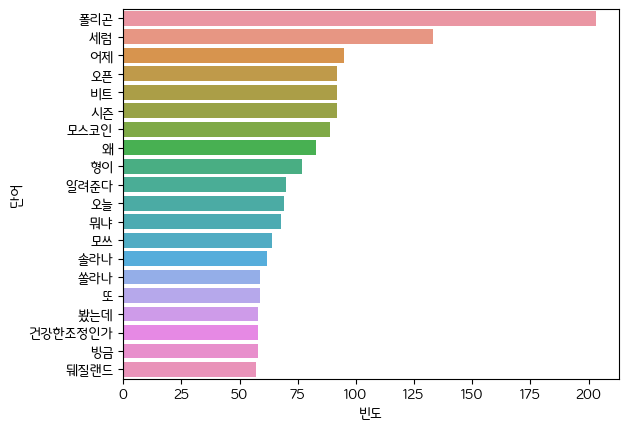

In [19]:
sns.barplot(data = top_df, x = '빈도', y = '단어')

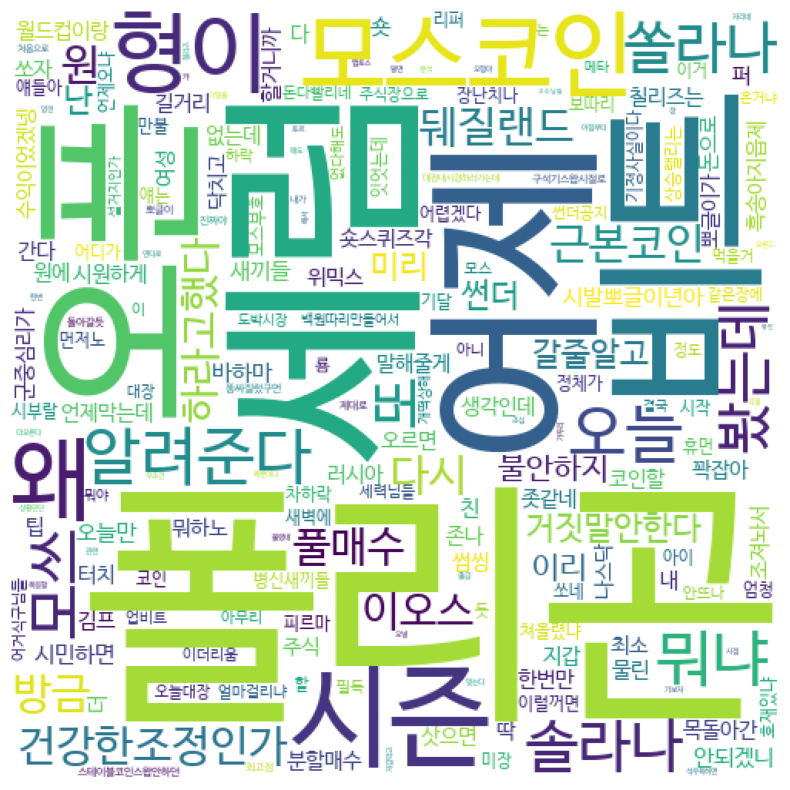

In [22]:
#WordCloud 형성
wc = WordCloud(font_path = 'C:\\Users\\cjsso\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothic.ttf', #폰트 위치(사용자에 맞게 설정)
    width = 500,
    height = 500,
    background_color='white').generate_from_frequencies(df.set_index('단어').to_dict()['빈도'])


plt.figure(figsize = (10, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [24]:
for lis in word_lis:
    while '새글' in lis:
        lis.remove('새글')
    while '이미지' in lis:
        lis.remove('이미지')
    while '첨부' in lis:
        lis.remove('첨부')

In [25]:
from gensim import corpora
coin_dict = corpora.Dictionary(word_lis)
corpus = [coin_dict.doc2bow(text) for text in word_lis]

In [26]:
import gensim

perplexity = []
for i in range(2,15):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=coin_dict)
    perplexity.append(ldamodel.log_perplexity(corpus))

c:\Users\cjsso\AppData\Local\R-MINI~1\envs\vspy\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


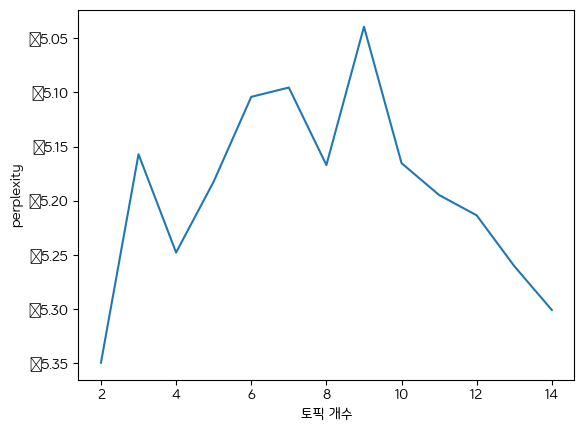

In [27]:
x = range(2,15)
plt.plot(x,perplexity)
plt.xlabel("토픽 개수")
plt.ylabel("perplexity")
plt.show()

In [32]:
from gensim.models import CoherenceModel

coherence = []
for i in range(2,20):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=coin_dict)
    coherence_mo_lda = CoherenceModel(model = ldamodel, texts = word_lis, dictionary = coin_dict, topn=10) 
    coherence_lda = coherence_mo_lda.get_coherence()
    coherence.append(coherence_lda)

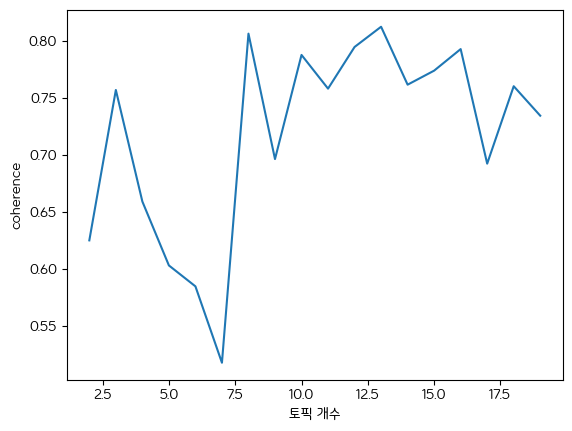

In [33]:
x = range(2,20)
plt.plot(x,coherence)
plt.xlabel("토픽 개수")
plt.ylabel("coherence")
plt.show()

In [34]:
NUM_TOPICS = 13
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=coin_dict, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.004*"폴리곤" + 0.004*"세럼" + 0.003*"오픈" + 0.003*"시즌" + 0.003*"비트"')
(1, '0.003*"알려준다" + 0.003*"형이" + 0.003*"폴리곤" + 0.003*"뭐냐" + 0.003*"모쓰"')
(2, '0.034*"오늘" + 0.029*"내가" + 0.026*"알려준다" + 0.016*"더오른다" + 0.016*"칠리즈"')
(3, '0.003*"형이" + 0.003*"모쓰" + 0.003*"뭐냐" + 0.003*"알려준다" + 0.003*"오늘"')
(4, '0.003*"폴리곤" + 0.003*"오늘" + 0.003*"알려준다" + 0.003*"썬더" + 0.003*"형이"')
(5, '0.004*"세럼" + 0.004*"최고점" + 0.004*"진짜야" + 0.004*"원" + 0.004*"뭐야"')
(6, '0.037*"폴리곤" + 0.037*"세럼" + 0.015*"러시아" + 0.015*"간다" + 0.015*"꽉잡아"')
(7, '0.058*"폴리곤" + 0.024*"썬더" + 0.012*"어제" + 0.012*"솔라나" + 0.012*"원에"')
(8, '0.073*"개같은코인판" + 0.073*"참" + 0.049*"찐반이네요" + 0.025*"진짜" + 0.025*"뽀글이나"')
(9, '0.045*"폴리곤" + 0.031*"왜" + 0.029*"비트" + 0.026*"시즌" + 0.026*"오픈"')
(10, '0.022*"가즈아" + 0.022*"지금" + 0.022*"세럼" + 0.011*"조장하던형들" + 0.011*"훼이크다"')
(11, '0.042*"오늘" + 0.026*"뭐냐" + 0.020*"모쓰" + 0.020*"듯" + 0.020*"정도"')
(12, '0.033*"형이" + 0.030*"뭐냐" + 0.029*"모쓰" + 0.021*"왜" + 0.020*"폴리곤"')


In [35]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, coin_dict)
pyLDAvis.display(vis)

c:\Users\cjsso\AppData\Local\R-MINI~1\envs\vspy\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
pyLDAvis.save_html(vis, pyldavis_html_path) #LDAvis save